In [1]:
# Visualize training data

# Visualize downsample with and without gaussian blur

In [2]:
import sys
sys.path.append("./SRGAN")
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import torchvision.transforms as T
to_img = T.ToPILImage()



In [536]:
CROP_SIZE = 128
UPSCALE_FACTOR = 2

In [563]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.01):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        mask = torch.rand(tensor.size()) > 0.9
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + mask * noise
    
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [564]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, GaussianBlur, Grayscale

def is_image_file(filename):
     return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
 return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
 return Compose([
     RandomCrop(crop_size),
     ToTensor(),
 ])


def train_lr_transform(crop_size, upscale_factor):
 return Compose([
     AddGaussianNoise(),
     ToPILImage(),
#      GaussianBlur(3, sigma=(0.1, 2.0)),
     Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
     ToTensor()
 ])


def display_transform():
 return Compose([
     ToPILImage(),
     Resize(400),
     CenterCrop(400),
     ToTensor()
 ])

In [565]:
class TrainDatasetFromFolder(Dataset):
     def __init__(self, dataset_dir, crop_size, upscale_factor):
         super(TrainDatasetFromFolder, self).__init__()
         self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
         crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
         self.hr_transform = train_hr_transform(crop_size)
         self.lr_transform = train_lr_transform(crop_size, upscale_factor)

     def __getitem__(self, index):
         hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
         lr_image = self.lr_transform(hr_image)
         return lr_image, hr_image

     def __len__(self):
         return len(self.image_filenames)
        
        
class ValDatasetFromFolder(Dataset):
     def __init__(self, dataset_dir, upscale_factor):
         super(ValDatasetFromFolder, self).__init__()
         self.upscale_factor = upscale_factor
         self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

     def __getitem__(self, index):
         hr_image = Image.open(self.image_filenames[index])
         w, h = hr_image.size
         crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
         lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
         hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
         hr_image = CenterCrop(crop_size)(hr_image)
         lr_image = lr_scale(hr_image)
         hr_restore_img = hr_scale(lr_image)
         return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

     def __len__(self):
         return len(self.image_filenames)

In [566]:
train_set = TrainDatasetFromFolder('SRGAN/data/miniplaces/train/corn_field', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder('SRGAN/data/miniplaces/val/corn_field', upscale_factor=UPSCALE_FACTOR)

train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=2, shuffle=False)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=1, shuffle=False)

In [567]:
img = next(iter(train_loader))

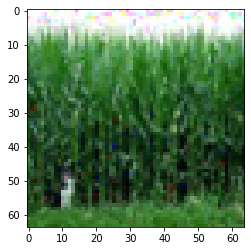

In [568]:
plt.imshow(to_img(img[0][0]))

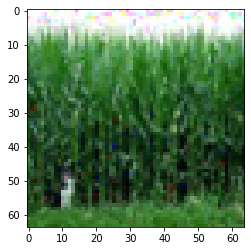

In [569]:
plt.imshow(to_img(img[0][0]))

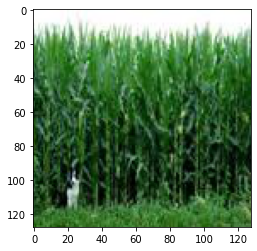

In [570]:
plt.imshow(to_img(img[1][0]))
# print((img[1][0])

In [571]:
import cv2

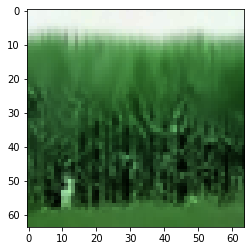

In [572]:
noiseimg = img[0][0]
# print(noiseimg.shape)
noiseimg = noiseimg.permute(1, 2, 0).numpy()
noiseimg = (noiseimg * 255).astype('uint8')
# print(noiseimg.shape)
dst = cv2.fastNlMeansDenoisingColored(noiseimg,None,10,10,7,21)
plt.imshow(dst)

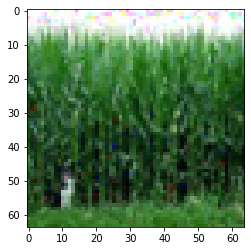

In [573]:
plt.imshow(to_img(img[0][0]))

In [574]:
# plt.imshow(to_img(img[1][0]))

In [521]:
# img[1].shape